In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import imageio

from naiveclassifier import NaiveClassifier
from expertclassifier import ExpertClassifier
from utils import ImageStreamer

traindatapath = 'train.csv'
cols = ['style', 'filename']
imgdir = r'D:\ArtStyle\Test'

data = pd.read_csv(traindatapath, header=0, names=cols)

In [15]:
downloaded_fnames = os.listdir(imgdir)
train_fnames = data['filename'].values
avail_fnames = [os.path.join(imgdir, f) for f in downloaded_fnames if f in train_fnames]

print('{0} files available out of {1} files downloaded.'.format(len(avail_fnames), len(downloaded_fnames)))

17117 files available out of 23817 files downloaded.


In [10]:
validation_split = 0.1  # as a fraction of the training set
train_split = 1 - validation_split

data = alldata.sample(frac=1, random_state=0).reset_index(drop=True)

num_instances = len(data)
num_train = int(np.ceil(train_split * num_instances))
num_val = int(np.ceil(validation_split * num_train))

val = alldata.iloc[num_train:]
train = alldata.iloc[:num_train]


# Naive Classifier

In [17]:
# Instantiate classifier and train
nc = NaiveClassifier()
nc.train(X=train['filename'].values, Y=train['style'].values)

# Evaluate on validation set
nc.evaluate(X=train['filename'].values, Y=train['style'].values)

0.1311937784958309

# Expert Classifier

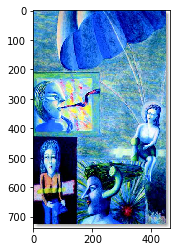

In [28]:
stream = ImageStreamer(avail_fnames[:10])
ec = ExpertClassifier()
plt.imshow(stream[0])